# DCGAN + conditional DCGAN


Notebook created by [Daniel Fojo](https://www.linkedin.com/in/daniel-fojo/) for the [Postgraduate course in artificial intelligence with deep learning](https://www.talent.upc.edu/ing/estudis/formacio/curs/310400/postgrau-artificial-intelligence-deep-learning/) in [UPC School](https://www.talent.upc.edu/ing/) (2020). Updated by [Mariona Carós](https://es.linkedin.com/in/mariona-c-a7bb91105) in 2022.
Minor contributions by [Gerard I. Gállego](https://www.linkedin.com/in/gerard-gallego/) and [Juan José Nieto](https://www.linkedin.com/in/juan-jose-nieto-salas/) during 2022.

In this notebook you will learn about Generative Adversarial Networks by implementing a DCGAN to generate images from noise.

**Important:** Set the Colab environment to run on GPU

In [ ]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets, utils
from PIL import Image
import numpy as np
import math
from IPython.display import display
from tqdm import tqdm
from itertools import cycle
from typing import Tuple

In [ ]:
seed = 123
np.random.seed(seed)
_ = torch.manual_seed(seed)
_ = torch.cuda.manual_seed(seed)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Defining the Hyper-parameters**

We now define the hyperparameters that are going to be used throughout the notebook to define the network.


In [61]:
hparams = {
    'batch_size':128,
    'num_epochs':10,
    'learning_rate':0.0002,
    'betas':(0.5, 0.999),
    'noise_size':100,
    'num_val_samples':25,
    'num_classes':10,
    'num_input_channels':1,
}

### Dataset and Data Loader
Download and prepare dataset and datalaoder


In [62]:
train_transforms = transforms.Compose([   
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=train_transforms,
)

dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=hparams['batch_size'], 
    shuffle=True,
)

# DCGAN

First, lets define our simple generator network.

### Exercise 1: Generator

The generator takes random noise as input and gives an image as output. Your exercise is to create the generator model.

It should follow these guidelines:
* The input will be a vector with random noise of size `noise_size`
* You should first apply a fully connected with output size 512\*4\*4 (channels\*height\*width)
* Then you should apply 3 blocks of:
    * TransposedConvolution with kernel size 4, stride 2 and padding 1. For the first 2 blocks, the output channels should be 256 and 128. For the third block, the output channels should be the correct one to generate images of the dataset.
    * BatchNorm2d except for the last block.
    * ReLU activation for the first 2 blocks and Tanh for the third block.

**Hint**: Remember to use reshape where necessary

In [63]:
class Generator(torch.nn.Module):
    
    def __init__(self, noise_size: int, num_input_channels: int):
        super().__init__()
      
        # TODO: Create the Fully connected layer using nn.Linear
        self.fc = nn.Linear(noise_size, 512*4*4)

        # TODO: Create the first block
        self.convt1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size = 4, stride=2, padding=1, bias=False), # (B, 256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        # TODO: Create the second block
        self.convt2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size = 4, stride=2, padding=1, bias=False), # (B, 128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # TODO: Create the third block using nn.Sequential with ConvTranspose2d, and activation
        self.convt3 = nn.Sequential(
            nn.ConvTranspose2d(128, num_input_channels, kernel_size = 4, stride=2, padding=1, bias=False), # (B, num_input_channels, 32, 32)
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        # TODO: Define the forward of the generator, x are random noise vectors (B, noise_size)
        x = self.fc(x)
        x = x.reshape(-1, 512, 4, 4) # (B, channels, height, width)
        x = self.convt1(x)
        x = self.convt2(x)
        x = self.convt3(x)        
        return x

Similarly, let's define a simple discriminator

### Exercise 2: Discriminator

The discriminator takes an image as input and classifies it between Real or Fake (1 or 0). Your exercise is to create the discriminator model.

It should follow these guidelines:
* The input will be an image of size `[num_input_channels, 32, 32]`
* You should apply 3 blocks of:
    * Convolution with kernel size 4, stride 2 and padding 1. The output channels should be 128, 256 and 512.
    * BatchNorm2d except for the first block.
    * LeakyReLU activation (alpha=0.2)
* Then you should apply a fully connected with input size 512\*4\*4 (channels\*height\*width) and the correct output size and activation for binary classification


**Hint**: Remember to use reshape/flatten where necessary

In [64]:
class Discriminator(torch.nn.Module):
    
    def __init__(self, num_input_channels: int):
        super().__init__()
        
        # TODO: Create the first block
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size = 4, stride=2, padding=1, bias=False), # (B, 128, 16, 16)
            nn.LeakyReLU(0.2),
        )

        # TODO: Create the second block
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size = 4, stride=2, padding=1, bias=False), # (B, 256, 8, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )

        # TODO: Create the third block
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size = 4, stride=2, padding=1, bias=False), # (B, 512, 4, 4)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        # TODO: Create the fully connected block using nn.Sequential with Linear and activation
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1),
            nn.Sigmoid(), # Binary classification (real vs false)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        # TODO: Define the forward of the discriminator, x are images (B, num_input_channels, 32, 32)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.reshape(x.shape[0], -1) # (B, channels * height * width)
        x = self.fc(x)
        return x

In [65]:
generator = Generator(hparams['noise_size'], hparams['num_input_channels']).to(device)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])

discriminator = Discriminator(hparams['num_input_channels']).to(device)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])

criterion = nn.BCELoss()

def init_weights(m):
    if type(m) in {nn.Conv2d, nn.ConvTranspose2d, nn.Linear}:
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias != None:
            torch.nn.init.constant_(m.bias, 0.0)
    if type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

generator.apply(init_weights)
discriminator.apply(init_weights);


## Train function

### Exercise 3: Train

Complete the code. Take into account which labels should be used at each step of the training.

In [66]:
def train_batch(
        real_samples: torch.Tensor, 
        generator: torch.nn.Module,
        discriminator: torch.nn.Module,
        optimizer_g: torch.optim,
        optimizer_d: torch.optim,
        ) -> Tuple[float, float]:

    generator.train()
    discriminator.train()
    
    bsz = real_samples.shape[0]
    
    # TODO: Define the labels for the real (ones) and fake (zeros) images of size (bsz, 1)
    label_real =  torch.ones(bsz, 1)
    label_fake =  torch.zeros(bsz, 1)

    label_real = label_real.to(device)
    label_fake = label_fake.to(device)

    ####################
    # OPTIMIZE GENERATOR
    ####################

    # Reset gradients
    optimizer_g.zero_grad()

    # Generate fake samples
    z = torch.randn(bsz, hparams['noise_size'], device=device) 
    fake_samples = generator(z) 
    
    # Evaluate the generated samples with the discriminator
    predictions_g_fake = discriminator(fake_samples) 
    # Calculate error with respect to what the generator wants
    loss_g = criterion(predictions_g_fake, label_real) 
        
    # Backpropagate
    loss_g.backward() 
    
    # Update weights (do a step in the optimizer)
    optimizer_g.step() 
    
    ########################
    # OPTIMIZE DISCRIMINATOR
    ########################

    fake_samples = fake_samples.detach() # Let's detach them to freeze the generator

    # Reset gradients
    optimizer_d.zero_grad()

    # Calculate discriminator prediction for real samples
    predictions_d_real = discriminator(real_samples)

    # Calculate error with respect to what the discriminator wants
    loss_d_real = criterion(predictions_d_real, label_real) 

    # Calculate discriminator loss for fake samples
    predictions_d_fake = discriminator(fake_samples) 

    # Calculate error with respect to what the discriminator wants
    loss_d_fake = criterion(predictions_d_fake, label_fake) 
    
    # Total discriminator loss
    loss_d = (loss_d_real + loss_d_fake) / 2
    loss_d.backward()

    # Update weights (do a step in the optimizer)
    optimizer_d.step() 

    return loss_g.item(), loss_d.item()


## Evaluation function

In [67]:
@torch.no_grad()
def evaluate(generator: torch.nn.Module, z_val: torch.Tensor) -> Image.Image:
    
    generator.eval()
    fake_samples = generator(z_val).cpu()
    # select a sample or create grid if img is a batch
    nrows = int(math.sqrt(fake_samples.shape[0]))
    img = utils.make_grid(fake_samples, nrow=nrows)

    # unnormalize
    img = (img*0.5 + 0.5)*255

    # to numpy
    image_numpy = img.numpy().astype(np.uint8)
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    
    return Image.fromarray(image_numpy)


## Train loop


Epoch: 1/10, batch: 200/469, G_loss: 2.061805248260498, D_loss: 0.12039533257484436


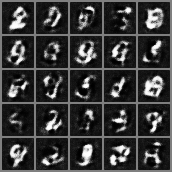


Epoch: 1/10, batch: 400/469, G_loss: 2.2578558921813965, D_loss: 0.10739171504974365


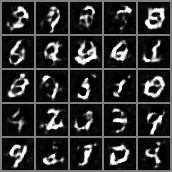


Epoch: 1/10, batch: 469/469, G_loss: 3.0056023597717285, D_loss: 0.4622449278831482


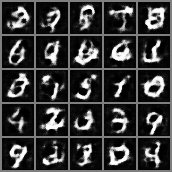


Epoch: 2/10, batch: 200/469, G_loss: 0.18392932415008545, D_loss: 1.1553236246109009


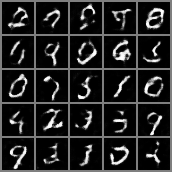


Epoch: 2/10, batch: 400/469, G_loss: 4.326427936553955, D_loss: 0.5973073840141296


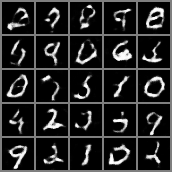


Epoch: 2/10, batch: 469/469, G_loss: 1.6184582710266113, D_loss: 0.4907693564891815


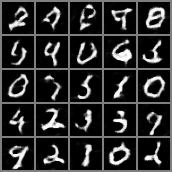


Epoch: 3/10, batch: 200/469, G_loss: 0.7101144790649414, D_loss: 0.6596088409423828


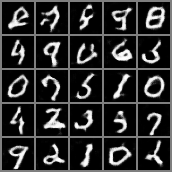


Epoch: 3/10, batch: 400/469, G_loss: 2.2278833389282227, D_loss: 0.10400767624378204


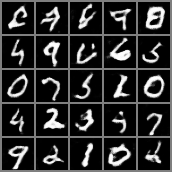


Epoch: 3/10, batch: 469/469, G_loss: 2.8976263999938965, D_loss: 0.12482000142335892


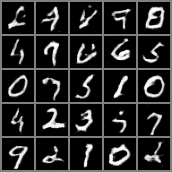


Epoch: 4/10, batch: 200/469, G_loss: 2.047236680984497, D_loss: 0.2522153854370117


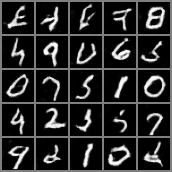


Epoch: 4/10, batch: 400/469, G_loss: 3.2116780281066895, D_loss: 0.1022721379995346


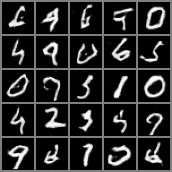


Epoch: 4/10, batch: 469/469, G_loss: 2.892824172973633, D_loss: 0.09164029359817505


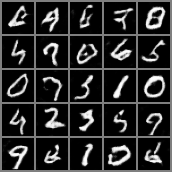


Epoch: 5/10, batch: 200/469, G_loss: 1.5799702405929565, D_loss: 0.42492225766181946


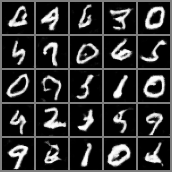


Epoch: 5/10, batch: 400/469, G_loss: 2.9312987327575684, D_loss: 0.1314772665500641


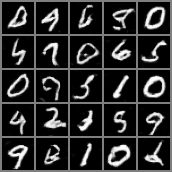


Epoch: 5/10, batch: 469/469, G_loss: 2.8926219940185547, D_loss: 0.08315800130367279


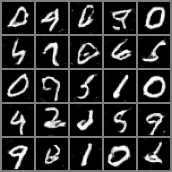


Epoch: 6/10, batch: 200/469, G_loss: 2.5709197521209717, D_loss: 0.06676789373159409


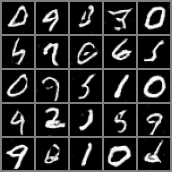


Epoch: 6/10, batch: 400/469, G_loss: 0.6463290452957153, D_loss: 0.8189882040023804


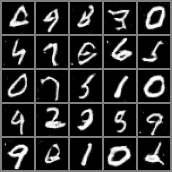


Epoch: 6/10, batch: 469/469, G_loss: 4.662179946899414, D_loss: 0.0208897665143013


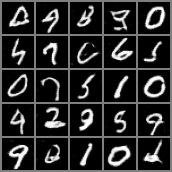


Epoch: 7/10, batch: 200/469, G_loss: 4.543571949005127, D_loss: 0.02020316570997238


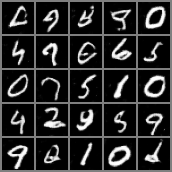


Epoch: 7/10, batch: 400/469, G_loss: 4.839313983917236, D_loss: 0.03425640985369682


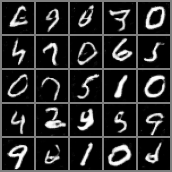


Epoch: 7/10, batch: 469/469, G_loss: 1.749634027481079, D_loss: 0.27132338285446167


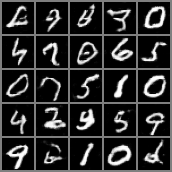


Epoch: 8/10, batch: 200/469, G_loss: 3.9100701808929443, D_loss: 0.023460472002625465


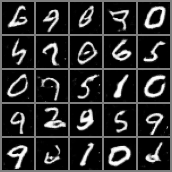


Epoch: 8/10, batch: 400/469, G_loss: 2.2204761505126953, D_loss: 0.2078450471162796


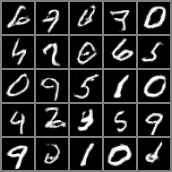


Epoch: 8/10, batch: 469/469, G_loss: 3.3051843643188477, D_loss: 0.14348918199539185


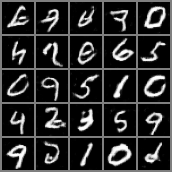


Epoch: 9/10, batch: 200/469, G_loss: 4.960907936096191, D_loss: 0.026861943304538727


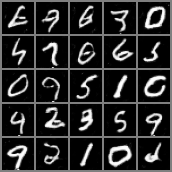


Epoch: 9/10, batch: 400/469, G_loss: 5.147392272949219, D_loss: 0.011312855407595634


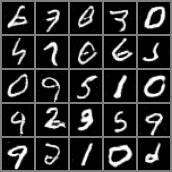


Epoch: 9/10, batch: 469/469, G_loss: 4.105781078338623, D_loss: 0.10920625925064087


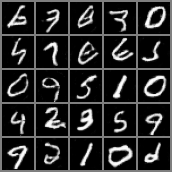


Epoch: 10/10, batch: 200/469, G_loss: 4.416559219360352, D_loss: 0.01655380055308342


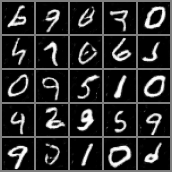


Epoch: 10/10, batch: 400/469, G_loss: 1.811032772064209, D_loss: 0.3917986750602722


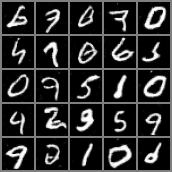


Epoch: 10/10, batch: 469/469, G_loss: 1.713484287261963, D_loss: 0.24531340599060059


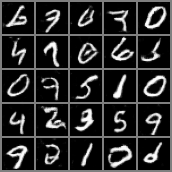

In [68]:
z_val = torch.randn(hparams['num_val_samples'], hparams['noise_size'], device=device)

for epoch in range(hparams['num_epochs']):

    for i, (real_samples, labels) in enumerate(dataloader):
        real_samples = real_samples.to(device)
        loss_g, loss_d = train_batch(real_samples, generator, discriminator, optimizer_g, optimizer_d)

        if (i+1) % 200 == 0:
            print(f"\nEpoch: {epoch+1}/{hparams['num_epochs']}, batch: {i+1}/{len(dataloader)},"
                  +f" G_loss: {loss_g}, D_loss: {loss_d}")
            
            fake_images = evaluate(generator, z_val)
            display(fake_images)

    print(f"\nEpoch: {epoch+1}/{hparams['num_epochs']}, batch: {i+1}/{len(dataloader)},"
          +f" G_loss: {loss_g}, D_loss: {loss_d}")
    
    fake_images = evaluate(generator, z_val)
    display(fake_images)
    

# Extra: Conditional GAN

### Exercise 4: Generator

We will now modify the generator from before to a conditional generator. To do it, we will concatenated the input to the convolutions with an embedding of the label we want to generate.

Complete the forward method. To do it, use the embedding layer with the label, and then use `torch.cat` to concatenate the label as a channel (after the corresponding `reshape`)

**Hint**: The embedding is concatenated as a new channel.

In [69]:
class ConditionalGenerator(torch.nn.Module):
    
    def __init__(
            self, 
            noise_size: int,
            num_input_channels: int,
            num_classes: int
            ) -> None:
        
        super().__init__()
      
        # TODO: Create the Fully connected layer using nn.Linear
        self.fc = nn.Linear(noise_size, 512*4*4)

        # Embedding of the class
        self.embedding = nn.Embedding(
            num_embeddings=num_classes, 
            embedding_dim=4*4,
        )

        # TODO: Create the first block
        self.convt1 = nn.Sequential(
            nn.ConvTranspose2d(512+1, 256, kernel_size = 4, stride=2, padding=1, bias=False), # (B, 256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        # TODO: Create the second block
        self.convt2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size = 4, stride=2, padding=1, bias=False), # (B, 128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # TODO: Create the third block using nn.Sequential with ConvTranspose2d, and activation
        self.convt3 = nn.Sequential(
            nn.ConvTranspose2d(128, num_input_channels, kernel_size = 4, stride=2, padding=1, bias=False), # (B, num_input_channels, 32, 32)
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor, label: int) -> torch.Tensor:
        
        # TODO: Define the forward of the generator, x are random noise vectors (B, noise_size)
        x = self.fc(x)
        x = x.reshape(-1, 512, 4, 4) # (B, channels, height, width)
        emb = self.embedding(label).reshape(-1, 1, 4, 4) # (B, 1, height, width)
        x = torch.cat((x, emb), dim=1)
        x = self.convt1(x)
        x = self.convt2(x)
        x = self.convt3(x)  
        
        return x

### Exercise 5: Discriminator

We will now modify the discriminator from before to a conditional discriminator. To do it, we will concatenated the input image with an embedding of the label we want to generate.

Complete the forward method. To do it, use the embedding layer with the label, and then use `torch.cat` to concatenate the label as a channel (after the corresponding `reshape`)

**Hint**: The embedding is concatenated as a new channel.

In [85]:
class ConditionalDiscriminator(torch.nn.Module):
    
    def __init__(self, 
                 num_input_channels: int,
                 num_classes: int):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=num_classes, 
            embedding_dim=32*32,
        )
        
        # TODO: Create the first block
        self.conv1 = nn.Sequential(
            nn.Conv2d(2, 128, kernel_size = 4, stride=2, padding=1, bias=False), # (B, 128, 16, 16)
            nn.LeakyReLU(0.2),
        )

        # TODO: Create the second block
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size = 4, stride=2, padding=1, bias=False), # (B, 256, 8, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )

        # TODO: Create the third block
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size = 4, stride=2, padding=1, bias=False), # (B, 512, 4, 4)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        # TODO: Create the fully connected block using nn.Sequential with Linear and activation
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1),
            nn.Sigmoid(), # Binary classification (real vs false)
        )

    def forward(self, x: torch.Tensor, label: int) -> torch.Tensor:
        # TODO: Define the forward of the discriminator, x are images (B, num_input_channels, 32, 32)
        emb = self.embedding(label).reshape(-1, 1, 32, 32) # (B, 1, 32, 32)
        x = torch.cat((x, emb), dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.reshape(x.shape[0], -1) # (B, channels * height * width)
        x = self.fc(x)

        return x
    

In [86]:
generator = ConditionalGenerator(hparams['noise_size'], hparams['num_input_channels'], 
                                 hparams['num_classes']).to(device)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=hparams['learning_rate'], 
                               betas=hparams['betas'])

discriminator = ConditionalDiscriminator(hparams['num_input_channels'],hparams['num_classes']).to(device)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])

criterion = nn.BCELoss()

def init_weights(m):
    if type(m) in {nn.Conv2d, nn.ConvTranspose2d, nn.Linear}:
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias != None:
            torch.nn.init.constant_(m.bias, 0.0)
    if type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

generator.apply(init_weights)
discriminator.apply(init_weights);


## Train function

In [87]:
def train_batch_conditional(
        real_samples: torch.Tensor, 
        real_classes: torch.Tensor,
        generator: torch.nn.Module,
        discriminator: torch.nn.Module,
        optimizer_g: torch.optim,
        optimizer_d: torch.optim,
        ) -> Tuple[float, float]:

    generator.train()
    discriminator.train()

    bsz = real_samples.shape[0]

    # TODO: Define the labels for the real (ones) and fake (zeros) images of size (bsz, 1)
    label_real =  torch.ones(bsz, 1)
    label_fake =  torch.zeros(bsz, 1)

    label_real = label_real.to(device)
    label_fake = label_fake.to(device)

    ####################
    # OPTIMIZE GENERATOR
    ####################

    # Reset gradients
    optimizer_g.zero_grad() 

    # Generate fake samples
    z = torch.randn(bsz, hparams['noise_size'], device=device) 
    fake_classes = torch.randint(0, 10, size=(bsz, 1), device=device)
    fake_samples = generator(z, fake_classes) 
    
    # Evaluate the generated samples with the discriminator
    predictions_g_fake = discriminator(fake_samples, fake_classes) 

    # Calculate error with respect to what the generator wants
    loss_g = criterion(predictions_g_fake, label_real) 

    # Backpropagate
    loss_g.backward() 
    
    # Update weights
    optimizer_g.step() 

    ########################
    # OPTIMIZE DISCRIMINATOR
    ########################

    fake_samples = fake_samples.detach()
    
    # Reset gradients
    optimizer_d.zero_grad() 

    # Calculate discriminator prediction for real samples
    predictions_d_real = discriminator(real_samples, real_classes) 

    # Calculate error with respect to what the discriminator wants
    loss_d_real = criterion(predictions_d_real, label_real) 

    # Calculate discriminator loss for fake samples
    predictions_d_fake = discriminator(fake_samples, fake_classes) 

    # Calculate error with respect to what the discriminator wants
    loss_d_fake = criterion(predictions_d_fake, label_fake) 
    
    # Total discriminator loss
    loss_d = (loss_d_real + loss_d_fake) / 2

    # Backpropagate
    loss_d.backward() 

    # Update weights
    optimizer_d.step() 

    return loss_g.item(), loss_d.item()


## Evaluation function

In [88]:
@torch.no_grad()
def evaluate_conditional(
        generator: torch.nn.Module,
        z_val: torch.Tensor,
        labels_val: torch.Tensor,
        ) -> Image.Image:
    
    generator.eval()
    fake_samples = generator(z_val, labels_val).cpu()
    # select a sample or create grid if img is a batch
    nrows = int(math.sqrt(fake_samples.shape[0]))
    img = utils.make_grid(fake_samples, nrow=nrows)

    # unnormalize
    img = (img*0.5 + 0.5)*255

    # to numpy
    image_numpy = img.numpy().astype(np.uint8)
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    return Image.fromarray(image_numpy)


## Train loop


Epoch: 1/10, batch: 200/469, G_loss: 4.001902103424072, D_loss: 0.07511386275291443


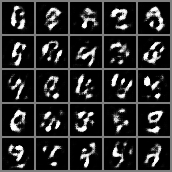


Epoch: 1/10, batch: 400/469, G_loss: 3.152846336364746, D_loss: 0.10130124539136887


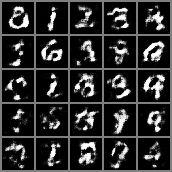


Epoch: 1/10, batch: 469/469, G_loss: 3.7044787406921387, D_loss: 0.16638867557048798


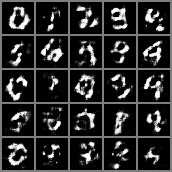


Epoch: 2/10, batch: 200/469, G_loss: 2.791421413421631, D_loss: 0.17313995957374573


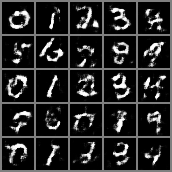


Epoch: 2/10, batch: 400/469, G_loss: 0.6534569263458252, D_loss: 0.6592753529548645


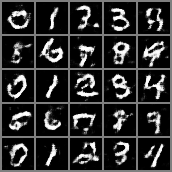


Epoch: 2/10, batch: 469/469, G_loss: 1.517404556274414, D_loss: 0.31287065148353577


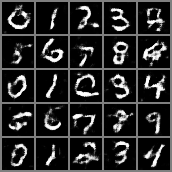


Epoch: 3/10, batch: 200/469, G_loss: 1.3974931240081787, D_loss: 0.4298352897167206


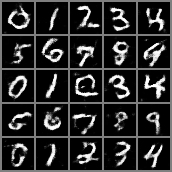


Epoch: 3/10, batch: 400/469, G_loss: 2.585452079772949, D_loss: 0.19521558284759521


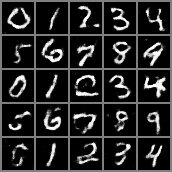


Epoch: 3/10, batch: 469/469, G_loss: 1.9848378896713257, D_loss: 0.2051379382610321


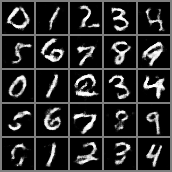


Epoch: 4/10, batch: 200/469, G_loss: 0.2392822802066803, D_loss: 1.0713906288146973


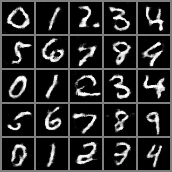


Epoch: 4/10, batch: 400/469, G_loss: 1.471353530883789, D_loss: 0.25135937333106995


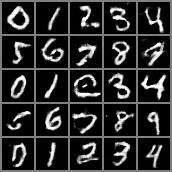


Epoch: 4/10, batch: 469/469, G_loss: 1.9863524436950684, D_loss: 0.1666685938835144


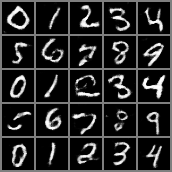


Epoch: 5/10, batch: 200/469, G_loss: 1.5511078834533691, D_loss: 0.300068199634552


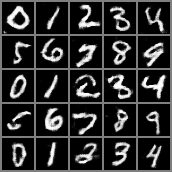


Epoch: 5/10, batch: 400/469, G_loss: 2.4713339805603027, D_loss: 0.09101377427577972


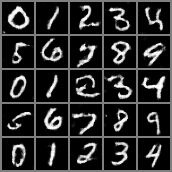


Epoch: 5/10, batch: 469/469, G_loss: 2.0498006343841553, D_loss: 0.3058164715766907


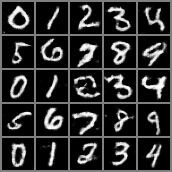


Epoch: 6/10, batch: 200/469, G_loss: 3.898484230041504, D_loss: 0.03537604585289955


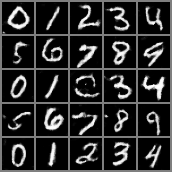


Epoch: 6/10, batch: 400/469, G_loss: 4.293523788452148, D_loss: 0.012995682656764984


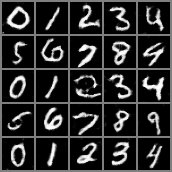


Epoch: 6/10, batch: 469/469, G_loss: 4.269845962524414, D_loss: 0.025093378499150276


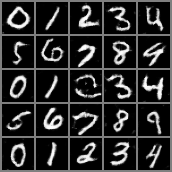


Epoch: 7/10, batch: 200/469, G_loss: 3.83111310005188, D_loss: 0.05178409442305565


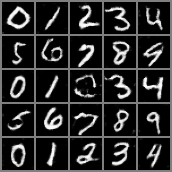


Epoch: 7/10, batch: 400/469, G_loss: 4.475366115570068, D_loss: 0.013246939517557621


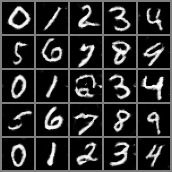


Epoch: 7/10, batch: 469/469, G_loss: 5.176143646240234, D_loss: 0.011022142134606838


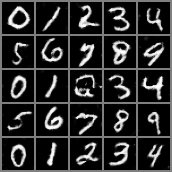


Epoch: 8/10, batch: 200/469, G_loss: 4.0219926834106445, D_loss: 0.015613092109560966


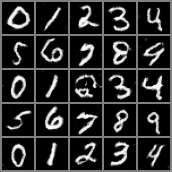


Epoch: 8/10, batch: 400/469, G_loss: 5.177759647369385, D_loss: 0.0056855399161577225


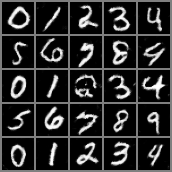


Epoch: 8/10, batch: 469/469, G_loss: 4.132174968719482, D_loss: 0.016917720437049866


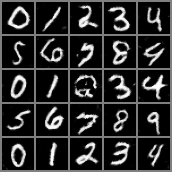


Epoch: 9/10, batch: 200/469, G_loss: 1.2063488960266113, D_loss: 0.5855717658996582


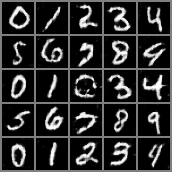


Epoch: 9/10, batch: 400/469, G_loss: 4.326452732086182, D_loss: 0.014053694903850555


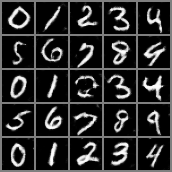


Epoch: 9/10, batch: 469/469, G_loss: 4.504027843475342, D_loss: 0.011514157056808472


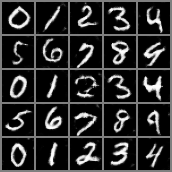


Epoch: 10/10, batch: 200/469, G_loss: 5.149711608886719, D_loss: 0.007798803970217705


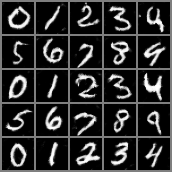


Epoch: 10/10, batch: 400/469, G_loss: 6.190401077270508, D_loss: 0.004447074607014656


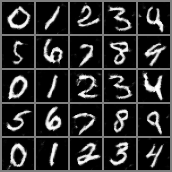


Epoch: 10/10, batch: 469/469, G_loss: 6.009139060974121, D_loss: 0.003679997753351927


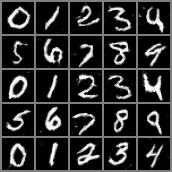

In [89]:
z_val = torch.randn(hparams['num_val_samples'], hparams['noise_size'], device=device)
labels_cycle = cycle(range(hparams['num_classes']))
labels_val = torch.tensor([next(labels_cycle) for i in range(hparams['num_val_samples'])],
                          device=device).unsqueeze(1) #the labels will be a cycle from 0 to 9

for epoch in range(hparams['num_epochs']):

    for i, (real_samples, real_classes) in enumerate(dataloader):
        real_samples = real_samples.to(device)
        real_classes = real_classes.unsqueeze(1).to(device)
        loss_g, loss_d = train_batch_conditional(
            real_samples, 
            real_classes, 
            generator, 
            discriminator, 
            optimizer_g, 
            optimizer_d,
        )

        if (i+1) % 200 == 0:
            print(f"\nEpoch: {epoch+1}/{hparams['num_epochs']}, batch: {i+1}/{len(dataloader)},"
                  + f" G_loss: {loss_g}, D_loss: {loss_d}")
            
            fake_images = evaluate_conditional(generator, z_val, labels_val)
            display(fake_images)

    print(f"\nEpoch: {epoch+1}/{hparams['num_epochs']}, batch: {i+1}/{len(dataloader)}, "
          + f"G_loss: {loss_g}, D_loss: {loss_d}")
    
    fake_images = evaluate_conditional(generator, z_val, labels_val)
    display(fake_images)
    

### Conditional generation

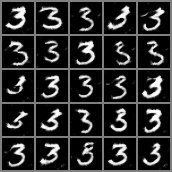

In [90]:
#You can play and visualize different numbers
number_chosen = 3
z_val = torch.randn(hparams['num_val_samples'], hparams['noise_size'], device=device)
number_chosen_torch = torch.tensor([
        number_chosen for i in range(hparams['num_val_samples'])
    ], 
    device=device).unsqueeze(1)

images_number_chosen = evaluate_conditional(generator, z_val, number_chosen_torch)
display(images_number_chosen)